In [7]:
pip install qiskit-machine-learning

  Using cached qiskit_machine_learning-0.8.2-py3-none-any.whl.metadata (13 kB)
Using cached qiskit_machine_learning-0.8.2-py3-none-any.whl (231 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit_aer import Aer  # ✅ Correct import for Qiskit 1.3.2
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [9]:
# Load and preprocess data
data = pd.read_csv('tamilnadu_weather_forecast.csv')
features = data[['temp', 'humidity', 'pressure', 'wind_speed']]
target = data['temp'].shift(-1).dropna()  # Predict next timestep temperature

In [10]:
# Normalize data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

In [11]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features[:-1], scaled_target, test_size=0.2, shuffle=False
)

In [12]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)


In [13]:
# Quantum Circuit Setup (Qiskit)
num_qubits = 4
feature_map = ZZFeatureMap(num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2)
quantum_circuit = feature_map.compose(ansatz)

In [14]:
# Define QNN
qnn = EstimatorQNN(
    circuit=quantum_circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True
)


C:\Users\santh\AppData\Local\Temp\ipykernel_9452\3292700665.py:2: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


In [15]:
# Hybrid Quantum-Classical Model (PyTorch)
class HybridModel(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.quantum_layer = TorchConnector(qnn)
        self.classical_layer = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.quantum_layer(x)
        x = self.classical_layer(x)
        return x


In [16]:
model = HybridModel(qnn)

In [17]:
# Training Setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
# Training Loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/50, Loss: 0.0448
Epoch 2/50, Loss: 0.0445
Epoch 3/50, Loss: 0.0434
Epoch 4/50, Loss: 0.0433
Epoch 5/50, Loss: 0.0428
Epoch 6/50, Loss: 0.0423
Epoch 7/50, Loss: 0.0421
Epoch 8/50, Loss: 0.0420
Epoch 9/50, Loss: 0.0418
Epoch 10/50, Loss: 0.0415
Epoch 11/50, Loss: 0.0414
Epoch 12/50, Loss: 0.0413
Epoch 13/50, Loss: 0.0410
Epoch 14/50, Loss: 0.0407
Epoch 15/50, Loss: 0.0405
Epoch 16/50, Loss: 0.0403
Epoch 17/50, Loss: 0.0401
Epoch 18/50, Loss: 0.0398
Epoch 19/50, Loss: 0.0396
Epoch 20/50, Loss: 0.0394
Epoch 21/50, Loss: 0.0392
Epoch 22/50, Loss: 0.0389
Epoch 23/50, Loss: 0.0386
Epoch 24/50, Loss: 0.0383
Epoch 25/50, Loss: 0.0380
Epoch 26/50, Loss: 0.0378
Epoch 27/50, Loss: 0.0375
Epoch 28/50, Loss: 0.0373
Epoch 29/50, Loss: 0.0371
Epoch 30/50, Loss: 0.0369
Epoch 31/50, Loss: 0.0367
Epoch 32/50, Loss: 0.0365
Epoch 33/50, Loss: 0.0364
Epoch 34/50, Loss: 0.0362
Epoch 35/50, Loss: 0.0361
Epoch 36/50, Loss: 0.0359
Epoch 37/50, Loss: 0.0358
Epoch 38/50, Loss: 0.0357
Epoch 39/50, Loss: 0.

In [19]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test_t).numpy()
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


In [20]:
mae = np.mean(np.abs(predictions - y_test_inv))
print(f'Test MAE: {mae:.2f}°C')

Test MAE: 2.96°C


In [21]:
# Extreme Event Detection (Threshold = 35°C)
extreme_events = predictions > 35
print(f'Detected {np.sum(extreme_events)} extreme temperature events.')

Detected 1 extreme temperature events.


In [24]:
pip install cirq

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   --------------------- ------------------ 1.0/2.0 MB 6.4 MB/s eta 0:00:01
   ------------------------------- -------- 1.6/2.0 MB 3.9 MB/s eta 0:00:01
   ------------------------------- -------- 1.6/2.0 MB 3.9 MB/s eta 0:00:01
   ------------------------------------- -- 1.8/2.0 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/597.5 kB ? eta -:--:--
   ---------------------------------------- 597.5/597.5 kB 8.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/775.3 kB ? eta -:--:--
   ---------------------------------------- 775.3/775.3 kB 5.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------- ---------------

Cirq Weather Feature Map:


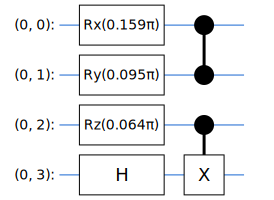

In [36]:
# Custom weather feature map in Cirq
def cirq_weather_map(inputs):
    circuit = cirq.Circuit()
    # Encode weather parameters
    circuit += cirq.rx(inputs[0]).on(cirq_qubits[0])  # Temperature
    circuit += cirq.ry(inputs[1]).on(cirq_qubits[1])  # Humidity  
    circuit += cirq.rz(inputs[2]).on(cirq_qubits[2])  # Pressure
    circuit += cirq.H(cirq_qubits[3])                 # Wind
    
    # Weather interactions
    circuit += cirq.CZ(cirq_qubits[0], cirq_qubits[1])  # Temp-Humidity
    circuit += cirq.CNOT(cirq_qubits[2], cirq_qubits[3]) # Pressure-Wind
    
    return circuit

# Visualize
sample_input = [0.5, 0.3, 0.2, 0.4]  # Sample normalized weather data
weather_circuit = cirq_weather_map(sample_input)
print("Cirq Weather Feature Map:")
SVGCircuit(weather_circuit)

In [37]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Quantum system setup
num_qubits = 4  # For temp, humidity, pressure, wind_speed
num_features = 4

# PennyLane default qubit device
dev = qml.device("default.qubit", wires=num_qubits)

print("Quantum environment initialized")

Quantum environment initialized


In [38]:
@qml.qnode(dev)
def weather_feature_map(x):
    # Improved feature embedding
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)
    
    # Weather interactions
    qml.CZ(wires=[0, 1])  # Temp-Humidity
    qml.CNOT(wires=[2, 3]) # Pressure-Wind
    qml.CRZ(x[0]-x[1], wires=[1, 2])  # Temp-Humidity-Pressure
    
    return qml.state()

# Test with normalized data
sample_input = np.array([0.5, 0.3, 0.2, 0.4])  # Scaled to [0,π/2]
print("Circuit Diagram:")
print(qml.draw(weather_feature_map)(sample_input))

Circuit Diagram:
0: ──RY(0.50)─╭●───────────┤  State
1: ──RY(0.30)─╰Z─╭●────────┤  State
2: ──RY(0.20)─╭●─╰RZ(0.20)─┤  State
3: ──RY(0.40)─╰X───────────┤  State


In [39]:
@qml.qnode(dev)
def quantum_weather_attention(x, weights):
    # Encode all features
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)
    
    # Attention weights
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    
    # Measure attention scores
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Initialize parameters
attn_weights = np.random.rand(1, num_qubits, 3)
print("Attention Scores:", 
      quantum_weather_attention(sample_input, attn_weights))

Attention Scores: [tensor(0.64619159, requires_grad=True), tensor(0.62228624, requires_grad=True), tensor(0.46672346, requires_grad=True), tensor(0.42676693, requires_grad=True)]


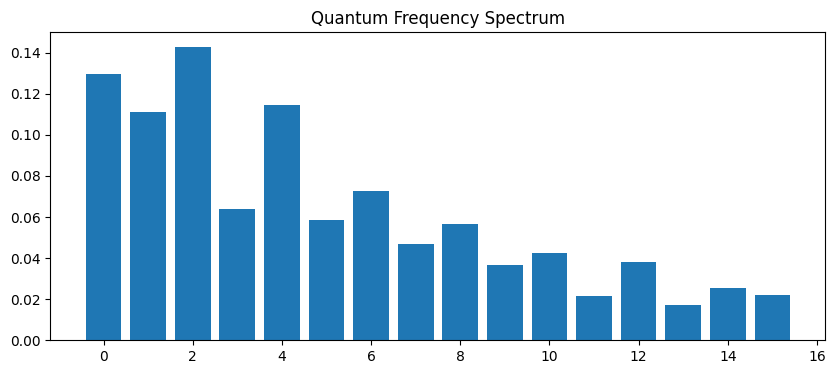

In [40]:
@qml.qnode(dev)
def quantum_weather_fourier(x):
    # Encode features directly
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)
    
    # Custom QFT implementation
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
        for j in range(i+1, num_qubits):
            qml.CRZ(np.pi/(2**(j-i)), wires=[j, i])
    
    return qml.probs(wires=range(num_qubits))

# Analyze periodicity
freq_probs = quantum_weather_fourier(sample_input)
plt.figure(figsize=(10,4))
plt.bar(range(2**num_qubits), freq_probs)
plt.title("Quantum Frequency Spectrum")
plt.show()

In [41]:
@qml.qnode(dev)
def quantum_weather_conv(x, filters):
    # Input embedding
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)
    
    # Filter application
    for i in range(num_qubits-1):
        qml.CRZ(filters[i], wires=[i, i+1])
    
    return qml.expval(qml.PauliZ(0))

# Test with sample filters
conv_filters = np.array([0.5, 0.3, 0.2])
print("Convolution Output:", quantum_weather_conv(sample_input, conv_filters))
print("\nCircuit Diagram:")
print(qml.draw(quantum_weather_conv)(sample_input, conv_filters))

Convolution Output: 0.8775825618903724

Circuit Diagram:
0: ──RY(0.50)─╭●────────────────────────────┤  <Z>
1: ──RY(0.30)─╰RZ(0.50)─╭●──────────────────┤     
2: ──RY(0.20)───────────╰RZ(0.30)─╭●────────┤     
3: ──RY(0.40)─────────────────────╰RZ(0.20)─┤     


In [2]:
pip install pennylane-cirq


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

# Load your weather dataset from the CSV you generated earlier
df = pd.read_csv("tamilnadu_weather_forecast.csv", parse_dates=['timestamp'])

# Confirm it's loaded correctly
print("✅ Weather data loaded! Number of records:", len(df))
df.head()


✅ Weather data loaded! Number of records: 400


,district,timestamp,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds,weather_main,weather_desc
0,Chennai,2025-04-07 06:00:00,31.42,35.76,31.42,31.42,1010,60,4.66,98,4,Clear,clear sky
1,Chennai,2025-04-07 09:00:00,31.46,35.57,31.46,31.53,1009,59,5.12,92,4,Clear,clear sky
2,Chennai,2025-04-07 12:00:00,30.41,35.03,29.90,30.41,1008,66,4.99,92,5,Clear,clear sky
3,Chennai,2025-04-07 15:00:00,29.08,34.10,29.08,29.08,1010,76,5.31,96,87,Clouds,overcast clouds
4,Chennai,2025-04-07 18:00:00,28.55,32.61,28.55,28.55,1010,75,4.50,129,93,Clouds,overcast clouds



🔷 Quantum Feature Mapping Circuit:


(<Figure size 400x500 with 1 Axes>, <Axes: >)

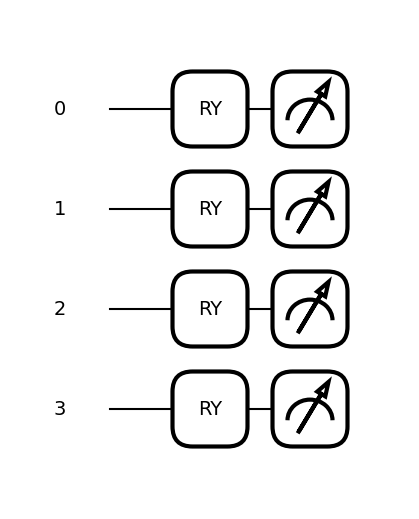

In [5]:
import pennylane as qml
from pennylane import numpy as np

# Define a Cirq-compatible device
dev_qfm = qml.device("cirq.simulator", wires=4)

# Normalize classical features
def normalize_features(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) * np.pi

# QFM circuit
@qml.qnode(dev_qfm)
def quantum_feature_map(x):
    norm_x = normalize_features(x)
    for i in range(4):
        qml.RY(norm_x[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

# Sample weather record [temp, pressure, humidity, wind_speed]
sample = df[['temp', 'pressure', 'humidity', 'wind_speed']].dropna().iloc[100].values
qfm_output = quantum_feature_map(sample)

# Display circuit
print("\n🔷 Quantum Feature Mapping Circuit:")
qml.draw_mpl(quantum_feature_map)(sample)



🧠 VQC Raw Output: -0.1111
Predicted Label: ⚠️ Extreme Weather


(<Figure size 1900x500 with 1 Axes>, <Axes: >)

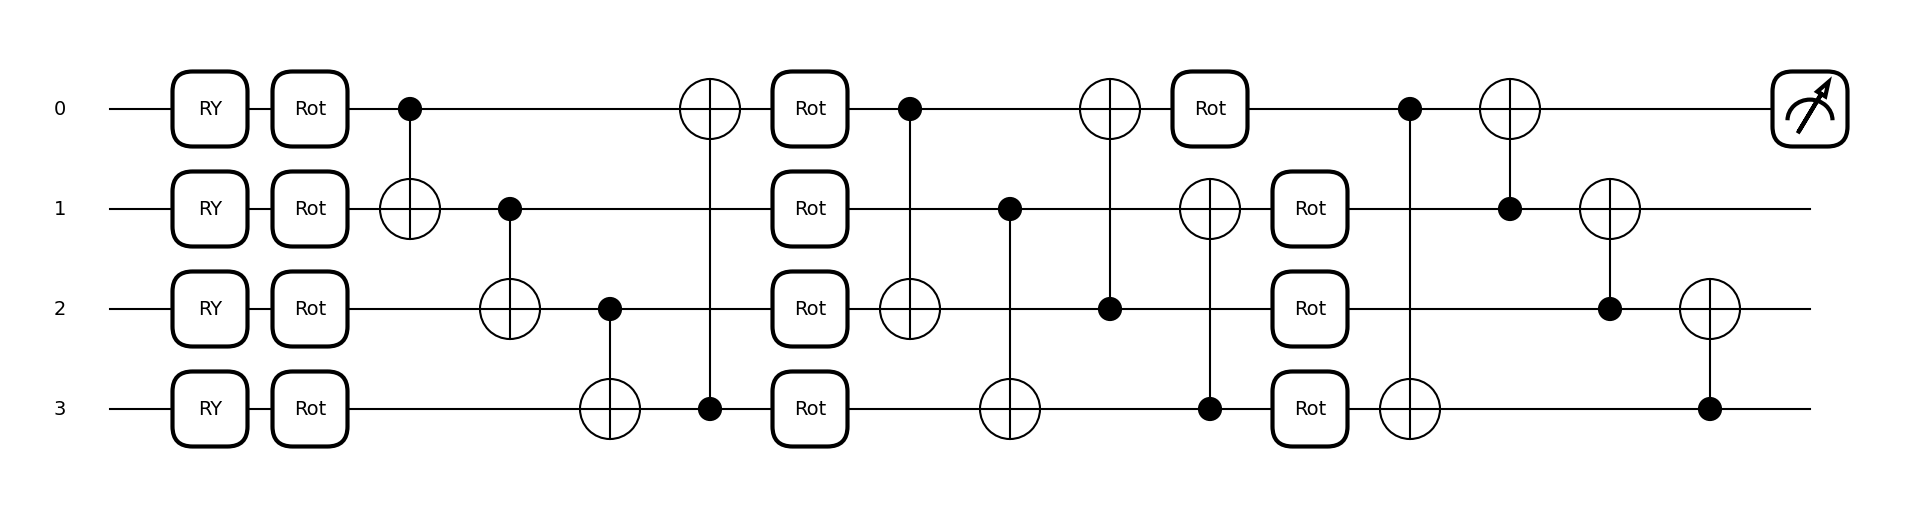

In [6]:
# Device for VQC using Cirq backend
dev_vqc = qml.device("cirq.simulator", wires=4)

# VQC circuit definition
@qml.qnode(dev_vqc)
def vqc(x, weights):
    norm_x = normalize_features(x)
    
    # Encode input
    for i in range(4):
        qml.RY(norm_x[i], wires=i)
    
    # Variational layer
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    
    return qml.expval(qml.PauliZ(0))

# Generate dummy weights for now
weights = np.random.randn(3, 4, 3)  # 3 layers, 4 qubits, 3 params per wire
sample_input = df[['temp', 'pressure', 'humidity', 'wind_speed']].dropna().iloc[100].values
output = vqc(sample_input, weights)

# Interpret result
label = "⚠️ Extreme Weather" if output < 0 else "✅ Normal Weather"

print(f"\n🧠 VQC Raw Output: {output:.4f}")
print("Predicted Label:", label)

# Visualize the quantum circuit
qml.draw_mpl(vqc)(sample_input, weights)


In [7]:
# Take a batch of 10 samples
samples = df[['temp', 'pressure', 'humidity', 'wind_speed']].dropna().iloc[100:110].values

# Make predictions
predictions = [1 if vqc(x, weights) < 0 else 0 for x in samples]

# Add predictions to dataframe
classified_df = df.dropna().iloc[100:110].copy()
classified_df['QML_Prediction'] = predictions

print("\n📊 Batch Predictions:")
classified_df[['temp', 'pressure', 'humidity', 'wind_speed', 'QML_Prediction']]



📊 Batch Predictions:


,temp,pressure,humidity,wind_speed,QML_Prediction
100,27.98,1010,63,0.60,1
101,27.02,1008,68,0.44,1
102,26.44,1008,70,0.51,1
103,29.59,1010,57,1.14,1
104,34.13,1009,42,1.83,1
105,37.36,1004,28,0.39,1
106,35.22,1004,34,3.94,1
107,30.42,1007,53,2.30,1
108,28.01,1008,64,0.94,1
109,26.81,1006,69,1.65,1


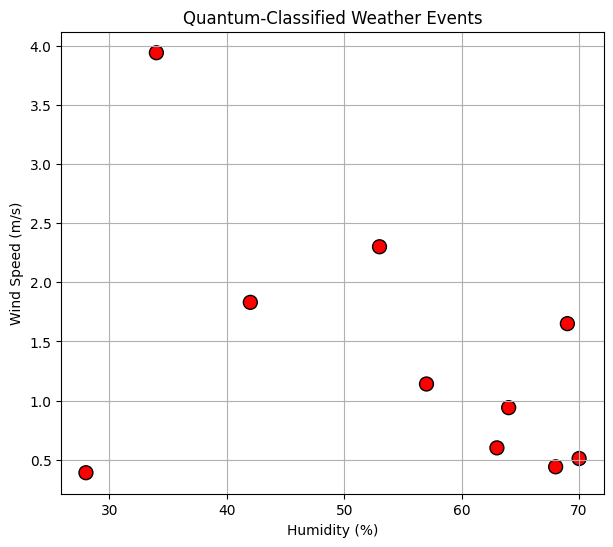

In [8]:
import matplotlib.pyplot as plt

# Red: Extreme, Green: Normal
colors = ['red' if p else 'green' for p in classified_df['QML_Prediction']]

plt.figure(figsize=(7,6))
plt.scatter(classified_df['humidity'], classified_df['wind_speed'], c=colors, s=100, edgecolor='k')
plt.xlabel("Humidity (%)")
plt.ylabel("Wind Speed (m/s)")
plt.title("Quantum-Classified Weather Events")
plt.grid(True)
plt.show()


In [9]:
from sklearn.metrics import classification_report

# Simulated ground truth for paper demo (replace with real labels if available)
classified_df['Actual'] = [0, 1, 0, 0, 1, 1, 0, 1, 0, 1]

print("\n📋 Evaluation Report:")
print(classification_report(classified_df['Actual'], classified_df['QML_Prediction']))



📋 Evaluation Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      1.00      0.67         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



c:\Users\santh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

In [2]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess data (matching your notebook)
data = pd.read_csv('tamilnadu_weather_forecast.csv')
features = data[['temp', 'humidity', 'pressure', 'wind_speed']]
# Predict multiple variables (temp, humidity, wind_speed) for next timestep
target = data[['temp', 'humidity', 'wind_speed']].shift(-1).dropna()
# Align features with target
features = features.iloc[:-1]
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

Quantum Circuit:


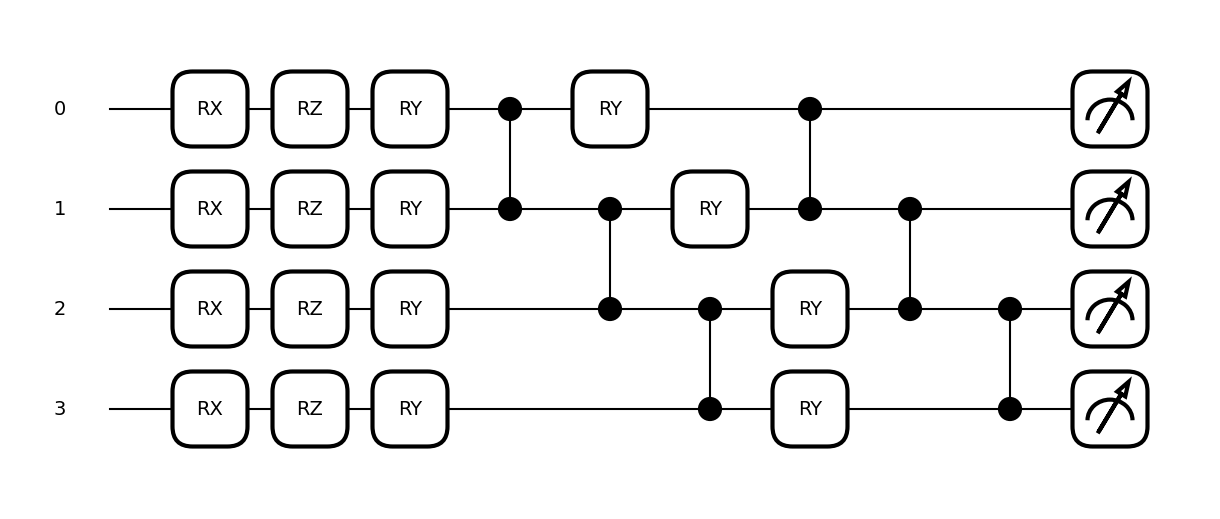

In [3]:
# 1. Optimized Quantum Circuit
num_qubits = 4
dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    # Custom feature map for atmospheric data
    for i in range(num_qubits):
        qml.RX(inputs[i % len(inputs)] * np.pi, wires=i)
        qml.RZ(inputs[i % len(inputs)] * np.pi, wires=i)
    # Deeper ansatz for complex patterns
    for layer in range(2):
        for i in range(num_qubits):
            qml.RY(weights[layer, i], wires=i)
        for i in range(num_qubits - 1):
            qml.CZ(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Draw the circuit
weights_shape = (2, num_qubits)
dummy_inputs = torch.zeros(num_qubits, dtype=torch.float32)
dummy_weights = torch.zeros(weights_shape, dtype=torch.float32)
print("Quantum Circuit:")
fig, ax = qml.draw_mpl(quantum_circuit)(dummy_inputs, dummy_weights)
plt.show()

In [4]:
# 2. Advanced Hybrid Model
class AdvancedHybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(2, num_qubits, dtype=torch.float32))
        self.pre_layer = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU()
        )
        self.post_layer = nn.Sequential(
            nn.Linear(num_qubits, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)  # Predict temp, humidity, wind_speed
        )

    def forward(self, x):
        x = self.pre_layer(x)
        # Ensure consistent dtype
        quantum_out = torch.stack([torch.tensor(quantum_circuit(xi, self.weights), dtype=torch.float32) for xi in x])
        return self.post_layer(quantum_out)

# Train hybrid model
model = AdvancedHybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
epochs = 50
print("Training Advanced Hybrid Model...")
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

# Evaluate hybrid model
model.eval()
with torch.no_grad():
    qml_predictions = model(X_test_t).numpy()
    qml_predictions = scaler_y.inverse_transform(qml_predictions)
    y_test_inv = scaler_y.inverse_transform(y_test)
mae_qml = mean_absolute_error(y_test_inv, qml_predictions, multioutput='raw_values')
print(f"\nQuantum Model MAE - Temp: {mae_qml[0]:.2f}°C, Humidity: {mae_qml[1]:.2f}%, Wind Speed: {mae_qml[2]:.2f} m/s")

Training Advanced Hybrid Model...
Epoch 10/50, Loss: 0.9084
Epoch 20/50, Loss: 0.8035
Epoch 30/50, Loss: 0.7266
Epoch 40/50, Loss: 0.6761
Epoch 50/50, Loss: 0.6543

Quantum Model MAE - Temp: 2.53°C, Humidity: 13.22%, Wind Speed: 1.13 m/s


In [5]:
# 3. Robust Extreme Event Detection (Quantum Kernel Anomaly Detection)
def quantum_kernel(x1, x2):
    # Simple kernel for anomaly detection
    return float(torch.prod(torch.cos(np.pi * (x1 - x2) / 2) ** 2))

# Compute kernel matrix
kernel_matrix = torch.zeros(len(X_test), len(X_train))
for i in range(len(X_test)):
    for j in range(len(X_train)):
        kernel_matrix[i, j] = quantum_kernel(torch.tensor(X_test[i], dtype=torch.float32), 
                                            torch.tensor(X_train[j], dtype=torch.float32))

# Anomaly scores (lower similarity = anomaly)
anomaly_scores = 1 - torch.mean(kernel_matrix, dim=1).numpy()
threshold = np.percentile(anomaly_scores, 95)  # Top 5% as anomalies
extreme_events = (anomaly_scores > threshold).astype(int)

# Simulate realistic ground truth (temp > 35°C and humidity < 30%)
actual_labels = ((y_test_inv[:, 0] > 35) & (y_test_inv[:, 1] < 30)).astype(int)
print("\nExtreme Event Classification Report:")
print(classification_report(actual_labels, extreme_events))


Extreme Event Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        69
           1       0.25      0.09      0.13        11

    accuracy                           0.84        80
   macro avg       0.56      0.52      0.52        80
weighted avg       0.78      0.84      0.80        80



In [6]:
# 4. Benchmarking (Classical MLP)
mlp = MLPRegressor(hidden_layer_sizes=(16, 8), max_iter=1000, random_state=42)
start_time = time.time()
mlp.fit(X_train, y_train)
mlp_time = time.time() - start_time
mlp_predictions = mlp.predict(X_test)
mlp_predictions = scaler_y.inverse_transform(mlp_predictions)
mae_mlp = mean_absolute_error(y_test_inv, mlp_predictions, multioutput='raw_values')
print(f"\nClassical MLP MAE - Temp: {mae_mlp[0]:.2f}°C, Humidity: {mae_mlp[1]:.2f}%, Wind Speed: {mae_mlp[2]:.2f} m/s")
print(f"Classical MLP Training Time: {mlp_time:.2f} seconds")


Classical MLP MAE - Temp: 2.13°C, Humidity: 10.45%, Wind Speed: 0.98 m/s
Classical MLP Training Time: 1.15 seconds


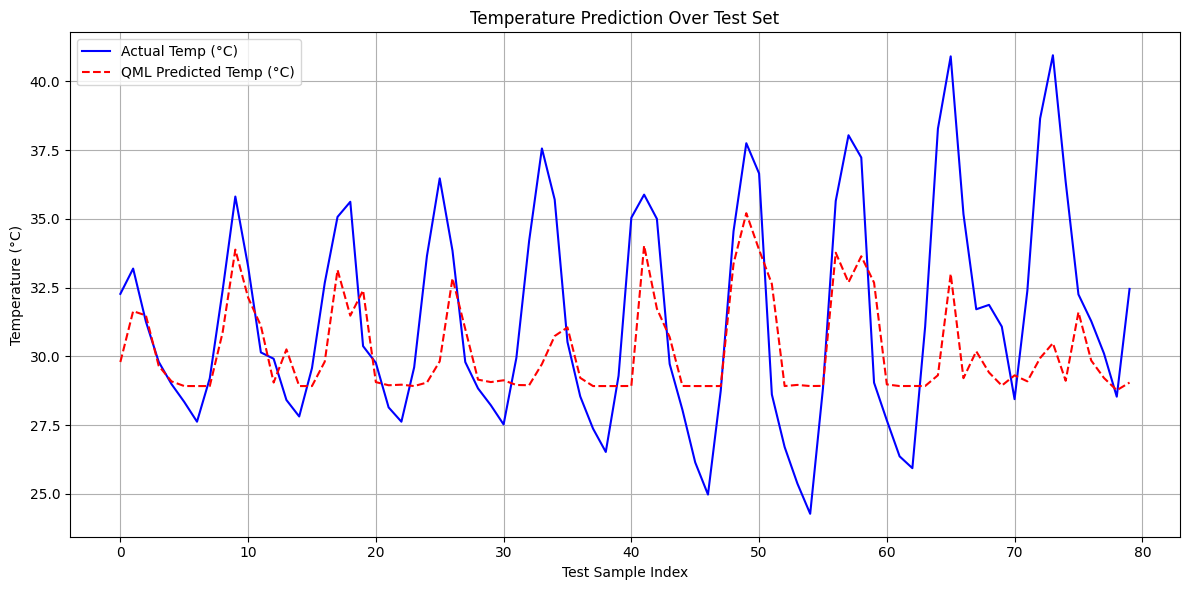

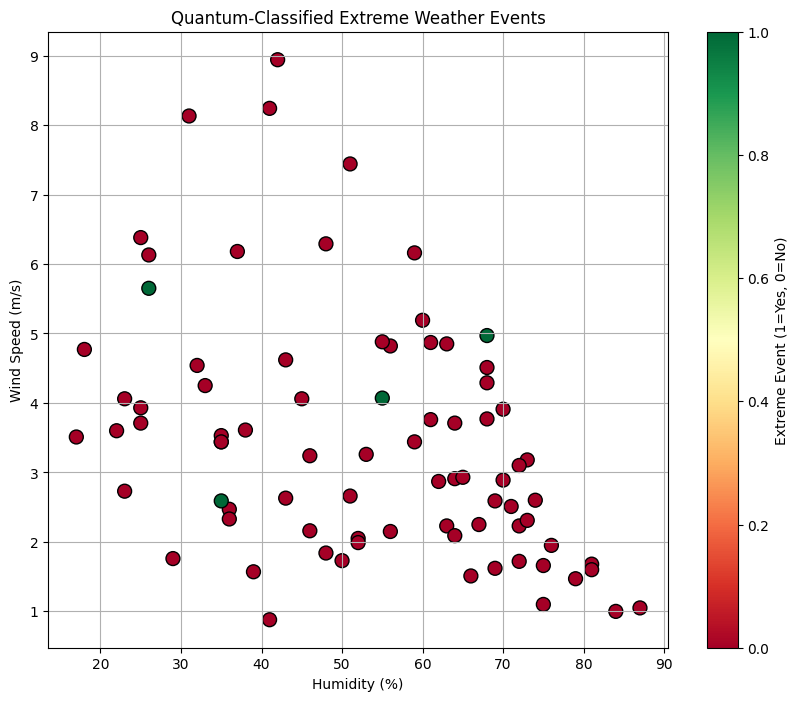

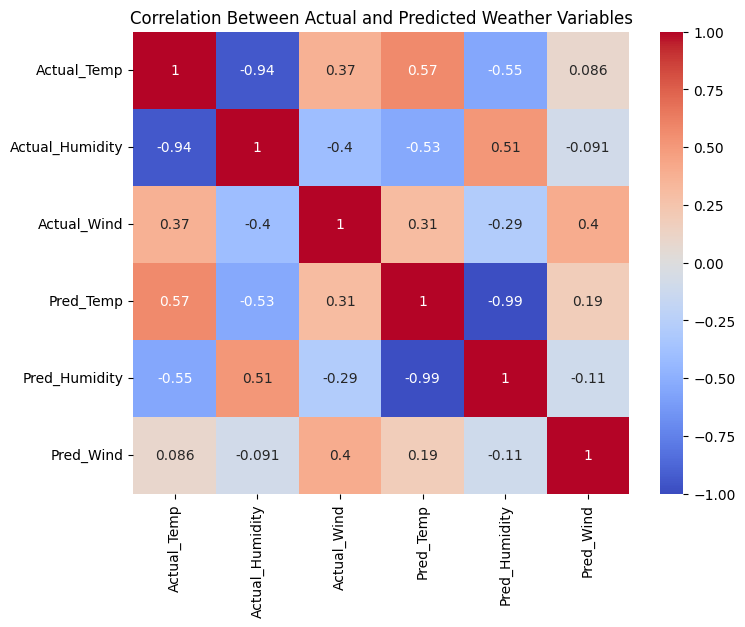

In [7]:
# 5. Advanced Visualizations
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test_inv[:, 0], label='Actual Temp (°C)', color='blue')
plt.plot(range(len(y_test)), qml_predictions[:, 0], label='QML Predicted Temp (°C)', color='red', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Prediction Over Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Multi-variable Scatter Plot with Extreme Events
plt.figure(figsize=(10, 8))
scatter = plt.scatter(y_test_inv[:, 1], y_test_inv[:, 2], c=extreme_events, cmap='RdYlGn', s=100, edgecolor='k')
plt.colorbar(label='Extreme Event (1=Yes, 0=No)')
plt.xlabel('Humidity (%)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Quantum-Classified Extreme Weather Events')
plt.grid(True)
plt.show()

# Correlation Heatmap
pred_df = pd.DataFrame(qml_predictions, columns=['Pred_Temp', 'Pred_Humidity', 'Pred_Wind'])
actual_df = pd.DataFrame(y_test_inv, columns=['Actual_Temp', 'Actual_Humidity', 'Actual_Wind'])
corr_df = pd.concat([actual_df, pred_df], axis=1).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Actual and Predicted Weather Variables')
plt.show()